In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano as T
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
from pymc3.variational.callbacks import CheckParametersConvergence
from pathlib import Path

In [3]:
model_path = Path ('/content/drive')
for p in [model_path]:
  if not p.exists():
    p.mkdir()

#Introduct to the Exam Data
here we have no prior knowledge about the dataset, basically we just gonnna assume which is not the way
but we gonna apply Bayesian knowledge
to solve any problem given the dataset
 
##Objectives

using Baye's theorem

$P(\theta|D)$ $=$ $\frac{P(\theta)P(D|\theta)} {P(D)}$

Where $P(\theta|D)$ ~ $Posterior$   $for$ $\theta$ $given$ $D$ $and$ $P(D|\theta)$ $~ Likelihood for$ $\theta$ 

$P(\theta)$ ~ $for$ $\theta$ and $P(D)$ $~$ 

Evidence of the model which we can simplify it as as:

$P(Model|Data)$ $=$ $\frac{P(Model)P(Data|Model)} {P(Data)}$

Model selection will be informed by the principle of Occam's Razor by selecting the easiest model that best explains the relation between the features $x_is$ and target variable $y_i$

$P(Model_i|Data)$ =$\frac{P(Model_i)P(Data|Model_i)} {P(Data)}$


*   Split the data set in Training and Validation sets
*   if there are missing values we take care of them
*   Taking care of Categorical Features
*   We Normalize the dataset

3.  Using  $X_is$ and $Y_i$
4. we will trace the model using arviz to check how uncertain and certain our model is

Currently I do not have research questions since I do not have prior knowledge about the dataset.. so according let's dive in




1. Encode a probability model by defining the following

* the prior distribution that quantify knowledge an uncertainty about latent variables
* the likelihood function that contains the parameters on observed data


2. Analyze the posterior using one of the options
* obtain a point estimate using MAP inference
* sample from the posterior using MCMC methods

3. Approximate the posterior using VI bayes
* check the model using various diag tools
* generate predictions

#Exploratory Data Analysis

 EDA is that it is a pre-processing step to understand our data, although we understand that there are many ways (or techniques) and step in performing EDA, however, numeroous of them are specific in focusing on either visualizatin or distribution, and are incomplete. EDA is used for seeking what the data can tell us before we performe the modelling task

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Exam_data.csv to Exam_data.csv


In [6]:
dt = pd.read_csv('Exam_data.csv', delimiter =';')
dt

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


now that we have loaded the dataset we can tell that it has 3276 rows and 10 columns
with 10  attributes
 first row already tell us the datasets has NaN values (missing values)
 data cleaning and data pre-processing needs to performed so that we can have a clean data

 we can also conclude given this dataset we can create a probabilistic logistic regression model simply because to determine if the sample tested from the water is fit for human consumption or not...
 using Potability as our target variable

In [7]:
dt.shape

(3276, 10)

In [8]:
dt.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


given the info above, we can deduce that we have 2 variable types
1. Binary: Potability
2. Continuous: sulfacate etc

check the type of variable

In [10]:
dt.nunique()

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64

In [11]:
dt.types

AttributeError: ignored

well the df has no types
now lets check for missing values

In [12]:
dt.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Missing values
* Ph has 491 values
* Sulfate has 781 values
* Trihalomethanes 162 values

the missing cales can be imputed by the mean of the complete cases of the variable

the variables with missinh values are treated as dependent variables and variables with complete cases are taken as predictors or independetn variables.

the disadvatange of this method, is that the identified indep variables would have high correlation with dep variable by virtue of selection. this would result in fitting the missng valuee a little too well and reducing the uncertainty about that value, also assuming that relationship is linear.

In [14]:
dt.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [15]:
(dt[['ph','Sulfate','Trihalomethanes']]==0).sum()

ph                 1
Sulfate            0
Trihalomethanes    0
dtype: int64

so it is ph that has missing values

there are three types of missing value
* MCAR
* MAR
* MNAR

we can choose to ignore the missing value
or we can drop the variable

In [18]:
import missingno as msno # visualize missing values



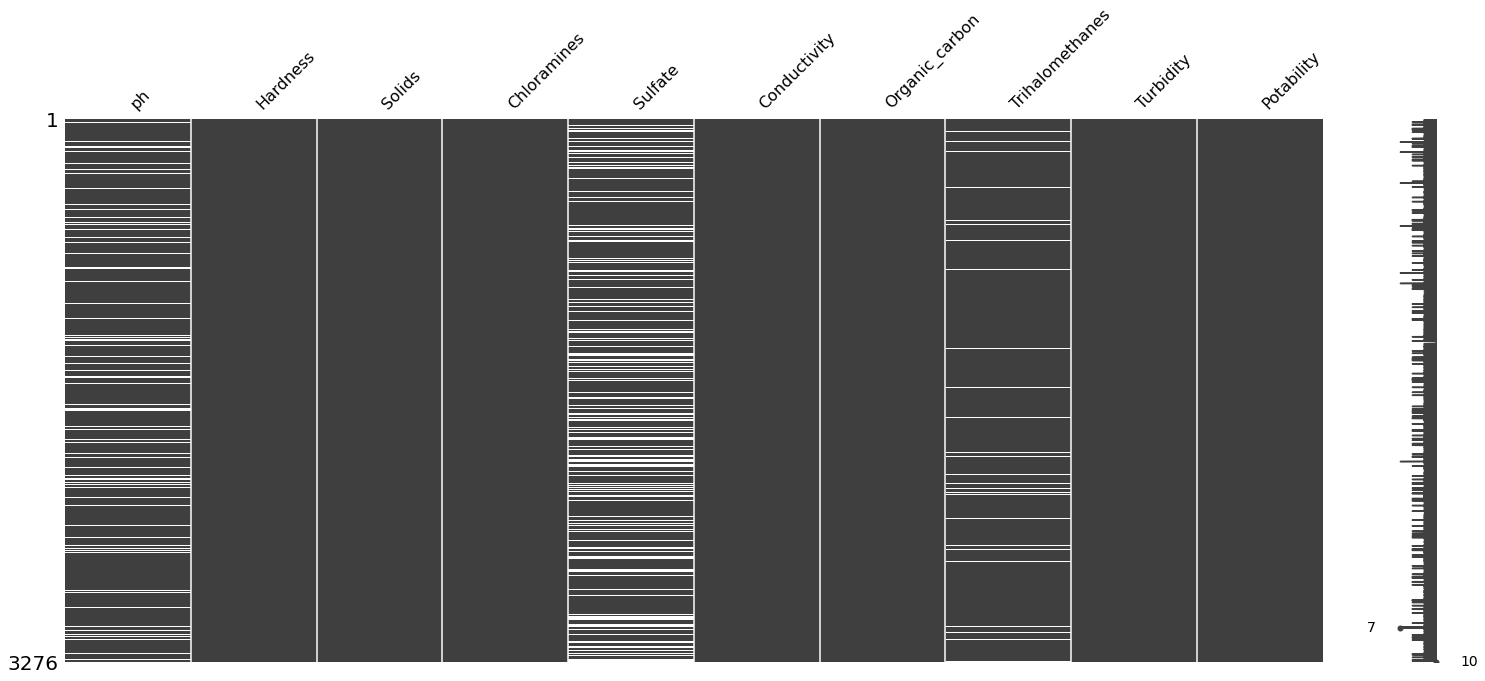

In [19]:
msno.matrix(dt)

Basically what the library does is visualize the missing values which are presented by the horizontal lines, this library also provide us with informative way of visualizing the missing values located in each column, and check whether there is any correlation between missing vales of different columns.

we will replace NaN values with Median

In [21]:
dt = dt.fillna(dt.median())
dt.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

lets see if we have any duplicated rows

In [22]:
duplicated = dt.duplicated().sum()
if duplicated:
  print('you have duplicates rows in the dataset which are: {}'.format(duplicated))
else:
  print('the dataset does not contain any duplicate value') 
  

the dataset does not contain any duplicate value


In [23]:
dt_vz = dt.copy()

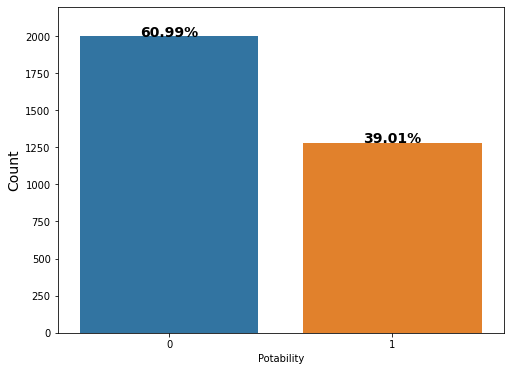

In [25]:
total = len(dt)
plt.figure(figsize=(8,6))
g = sns.countplot(x='Potability', data=dt)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
      height +1.5,
      '{:1.2f}%'.format(height/total*100),
      ha = "center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

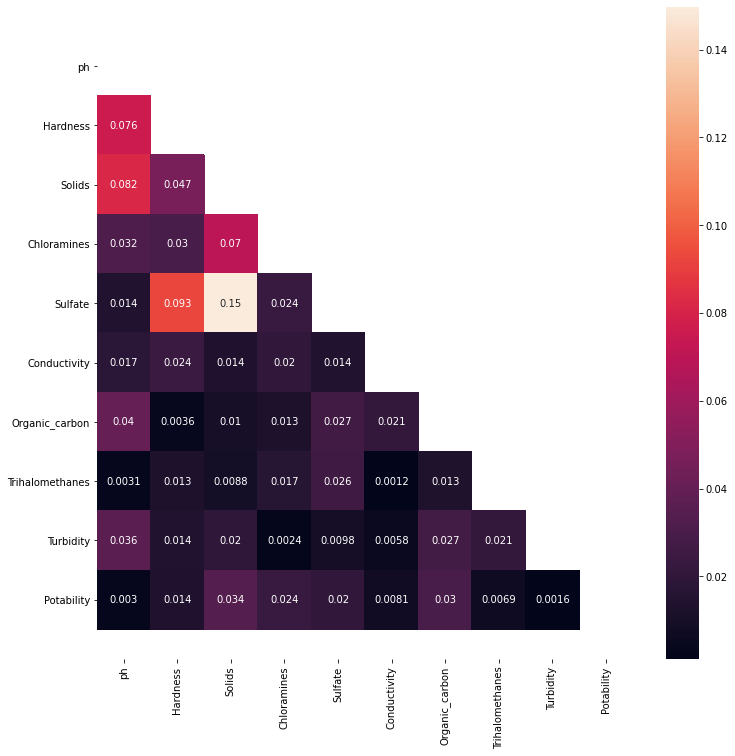

In [27]:
plt.figure(figsize=(12,12))
corr = dt.corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot= True)
b,t= plt.ylim()
b +=.5
t -= .5
plt.ylim(b,t)
plt.show()

In [31]:
import matplotlib.cm as cm

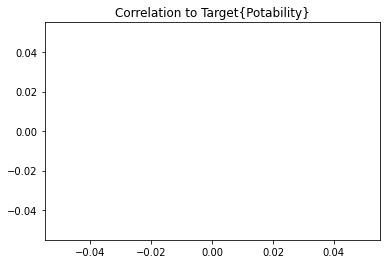


 Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.006887
Turbidity          0.001581
ph                -0.003014
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.020476
Organic_carbon    -0.030001
dtype: float64


In [36]:
n_fits = len(dt.columns)
colors = cm.rainbow(np.linspace(0,1, n_fits))

dt.drop('Potability', axis=1).corrwith(dt.Potability).sort_values(ascending = True)
plt.plot(kind='barh',
colors = colors, figsize= (12,8))
plt.title('Correlation to Target{Potability}')
plt.show()

print('\n', dt.drop('Potability',axis=1).corrwith(dt.Potability).sort_values(ascending=False))

In [40]:
dt['Organic_carbon'] = -dt['Organic_carbon']
dt['Sulfate'] = -dt['Sulfate']
dt['Hardness'] = -dt['Hardness']
dt['Conductivity'] = -dt['Conductivity']
dt['ph'] = -dt['ph']
dt['Solids'] = dt['Solids']
dt['Chloramines'] = dt['Chloramines']
dt['Trihalomethanes'] = dt['Trihalomethanes']
dt['Turbidity'] = dt['Turbidity']

corr = dt.corr()

cor_target = corr["Potability"]

rel_feat = cor_target[cor_target>0.08]
rel_feat.sort_values(ascending = False)

Potability    1.0
Name: Potability, dtype: float64

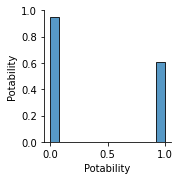

In [42]:
sns.pairplot(dt[rel_feat.index]);

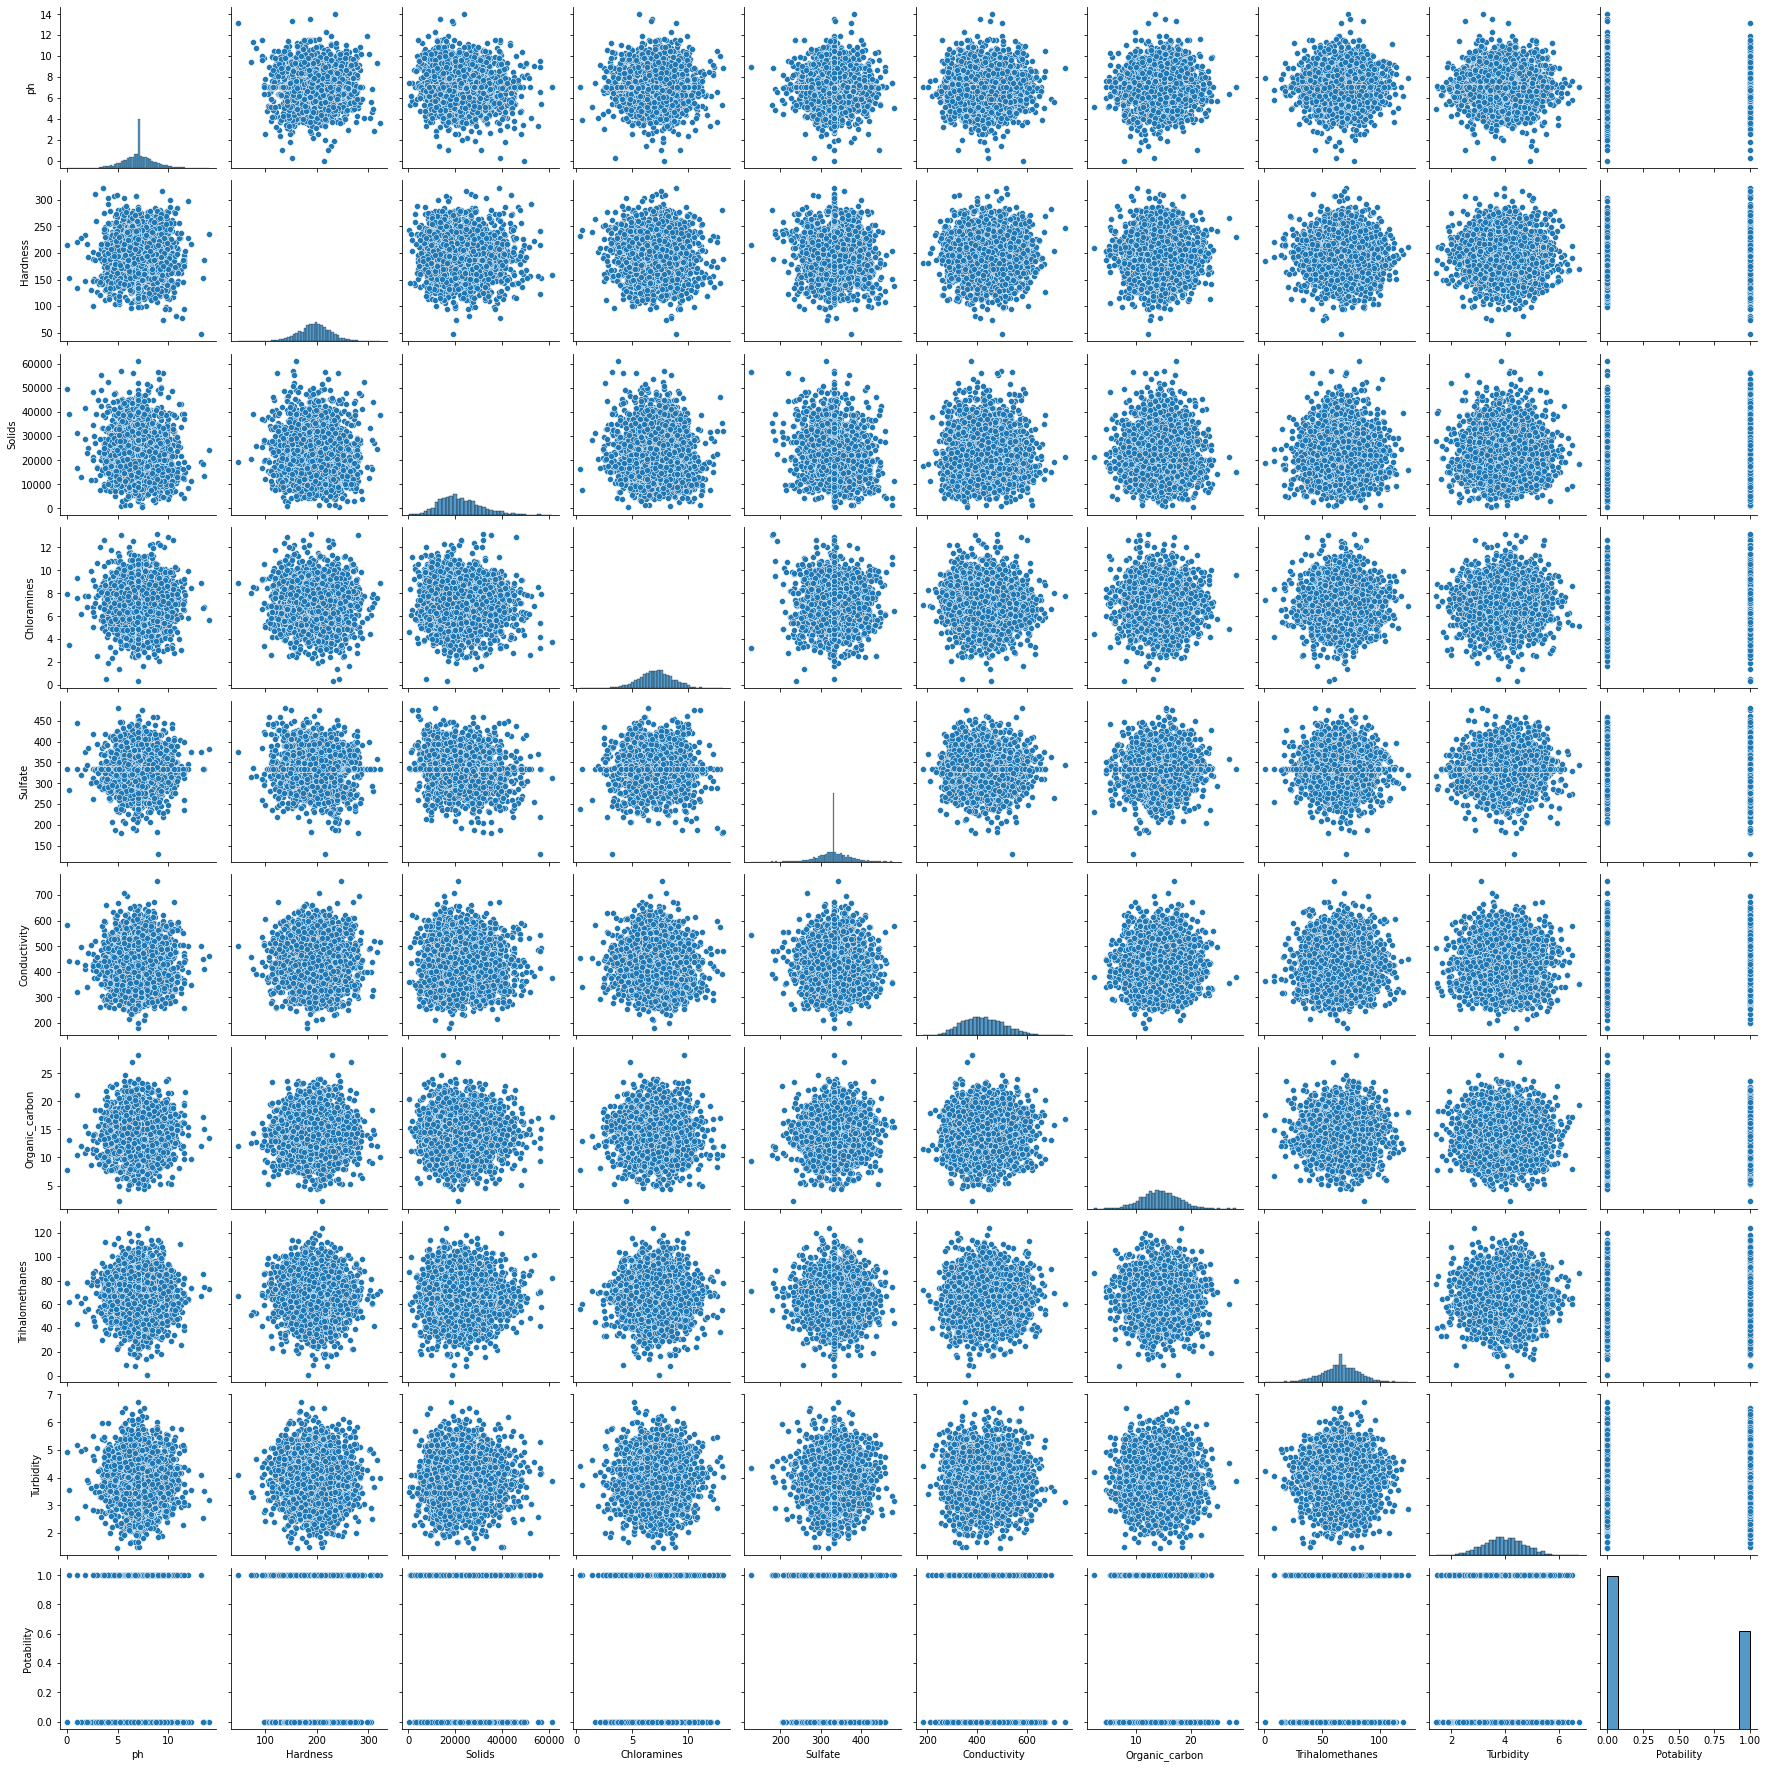

In [37]:
sns.pairplot(dt)

# MAP Inference
$\sigma$ is the logistic function

$\sigma(t)$  $=$ $\frac{ 1} {1+ e^-{1}}$

Manual Model SPecs
* random variables for the unoberseved parameres and 4 features are expressed using uninformative priors that assume normal distribution with mean =0 and std = 15
* likelihood combines the parameters with data according to the specs of logistic regression

* the outcome is modeled as a BernoulliRv with success probability given by the likelihood

In [43]:
with pm.Model() as manual_lg_model:
    #rv for  coeffs with uninformative priors for each params

    inter = pm.Normal('inter', 0, sd=15)
    beta_1 = pm.Normal('beta_1', 0, sd=15)
    beta_2 = pm.Normal('beta_2', 0, sd =15)
    beta_3 = pm.Normal('beta_3',0, sd=15)
    beta_4 = pm.Normal('beta_4', 0, sd=15)
    beta_5 = pm.Normal('beta_5', 0, sd=15)

    #transform rv into vector of pbs p(yi=1)
    likelihood = pm.invlogit(inter+beta_1 * dt.Sulfate + beta_2* dt.Hardness +beta_3*dt.ph +beta_4*dt.Conductivity +beta_5*dt.Organic_carbon)

    #bernoulli rv with probability of success
    #given sigmoid func and actualdata as observed
    pm.Bernoulli(name='logit', p= likelihood, observed = dt.Potability)

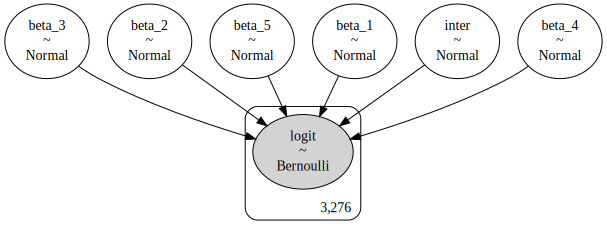

In [46]:
pm.model_to_graphviz(manual_lg_model)

#MAP estimate
Maximum a posteriori probability (MAP) estimation leverages that the evidence is a constant factor that scalesthe posterior to meet the requirements for a probability distribution. Since the evidence does not depend on
,the posterior distribution is proportional to the product of the likelihood and the prior. Hence, MAP estimationchooses the value of
that maximizes the posterior given the observed data and the prior belief, that is, themode of the posterior.

$\theta_{MAP} = arg_{\theta}max P(X|\theta)P(\theta)$

we obtain point MAP estimates for three 4 parameters using defined find_MAP() method

In [47]:
with manual_lg_model:
  #compute maximum a [posterior] estimate
  #for logistic regg weights
  manual_map_estimate = pm.find_MAP()

In [48]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k,v in result.items()})

In [49]:
print_map(manual_map_estimate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


inter     0.001369
beta_1    0.000518
beta_2    0.000473
beta_3   -0.006775
beta_4    0.000037
beta_5    0.015224
dtype: float64

# GLM Model
logistic reg as member of Generalized Linear Models (GLM)

In [51]:
simple_model = 'Potability~  Sulfate + Hardness + ph + Conductivity + Organic_carbon'
full_model =  'Potability~  Sulfate + Hardness + ph + Conductivity + Organic_carbon +Solids +Chloramines +Trihalomethanes +Turbidity'

In [52]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            dt,
                            family = pm.glm.families.Binomial())

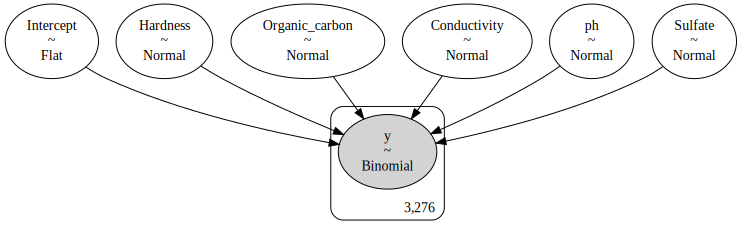

In [53]:
pm.model_to_graphviz(logistic_model)

# Markov Chain Monte Carlo
Markov chains are stochastic models that describe sequences of possible events. Each event comes from a setof outcomes, and each outcome determines which outcome occurs next, according to a fixed set of probabilities.An important feature of Markov chains is that they are
memoryless:
everything that you would possibly need topredict the next event is available in the current state, and no new information comes from knowing historicalevents.



In [56]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=dt,
                            family = pm.glm.families.Binomial())

In [57]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 Sulfate ~ Normal,
 Hardness ~ Normal,
 ph ~ Normal,
 Conductivity ~ Normal,
 Organic_carbon ~ Normal,
 Solids ~ Normal,
 Chloramines ~ Normal,
 Trihalomethanes ~ Normal,
 Turbidity ~ Normal,
 y ~ Binomial]

In [61]:
with logistic_model:
  trace = pm.sample(tune=1000, draws=1000,
                    chains=4, init='adapt_diag',
                    cores=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [Turbidity, Trihalomethanes, Chloramines, Solids, Organic_carbon, Conductivity, ph, Hardness, Sulfate, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 571 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac95db8c10>,
      dtype=object)

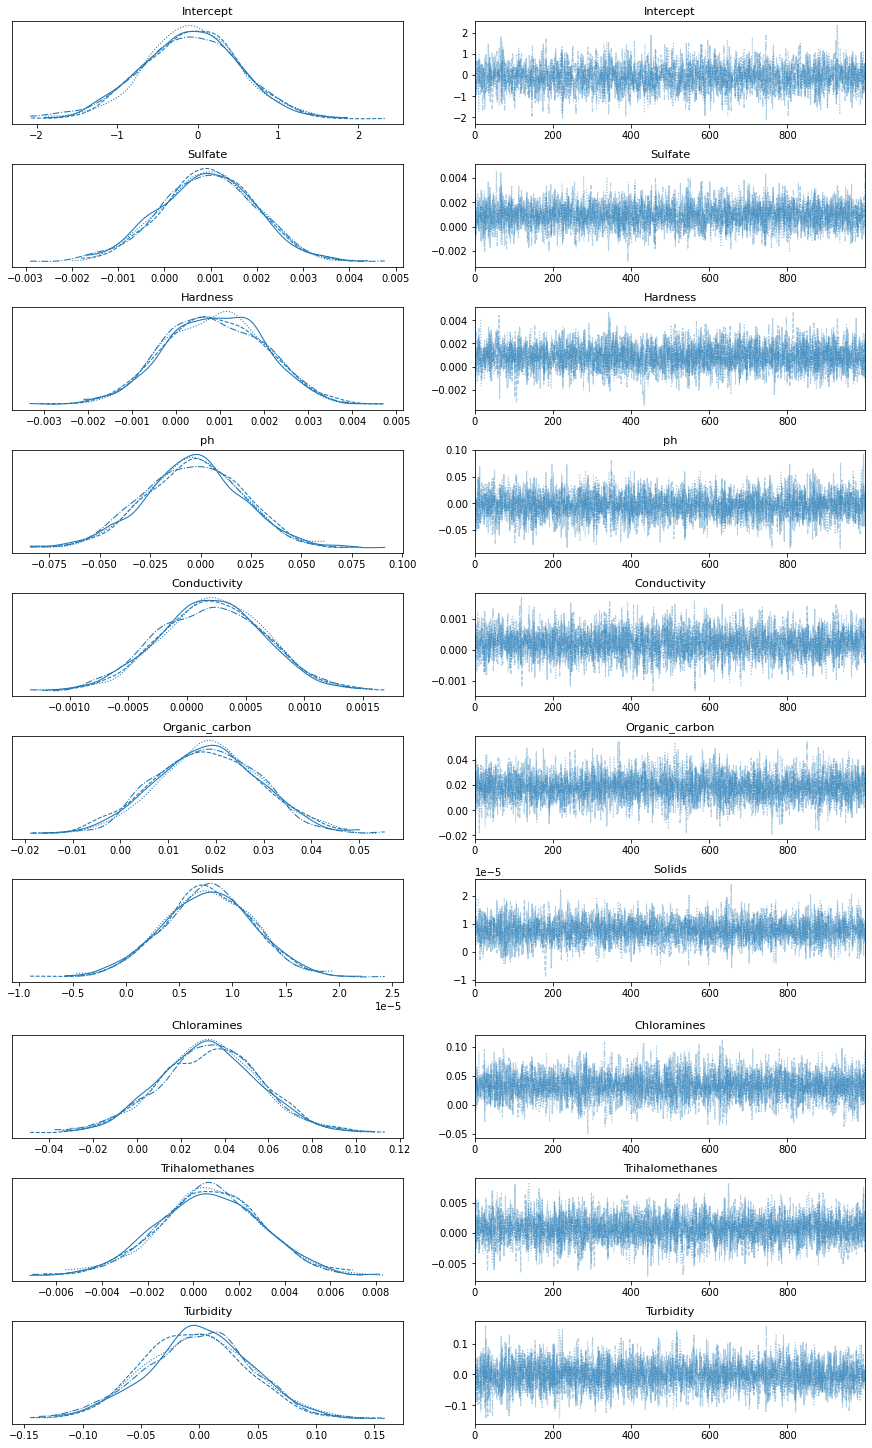

In [65]:
pm.plot_trace(trace)

In [66]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Intercept        4000 non-null   float64
 1   Sulfate          4000 non-null   float64
 2   Hardness         4000 non-null   float64
 3   ph               4000 non-null   float64
 4   Conductivity     4000 non-null   float64
 5   Organic_carbon   4000 non-null   float64
 6   Solids           4000 non-null   float64
 7   Chloramines      4000 non-null   float64
 8   Trihalomethanes  4000 non-null   float64
 9   Turbidity        4000 non-null   float64
dtypes: float64(10)
memory usage: 312.6 KB


In [67]:
with open(model_path/'logistic_model_mh.pkl','wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace}, buff)

In [68]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.080,0.605,-1.234,1.043,0.012,0.010,2765.0,2845.0,1.0
Sulfate,0.001,0.001,-0.001,0.003,0.000,0.000,3774.0,2959.0,1.0
Hardness,0.001,0.001,-0.001,0.003,0.000,0.000,4327.0,3050.0,1.0
ph,-0.004,0.024,-0.049,0.040,0.000,0.000,4286.0,2752.0,1.0
Conductivity,0.000,0.000,-0.001,0.001,0.000,0.000,4366.0,2835.0,1.0
Organic_carbon,0.018,0.011,-0.001,0.040,0.000,0.000,4125.0,3034.0,1.0
Solids,0.000,0.000,-0.000,0.000,0.000,0.000,4160.0,2491.0,1.0
Chloramines,0.033,0.023,-0.012,0.075,0.000,0.000,4720.0,3058.0,1.0
Trihalomethanes,0.001,0.002,-0.003,0.005,0.000,0.000,4339.0,2568.0,1.0
Turbidity,-0.001,0.045,-0.088,0.079,0.001,0.001,4436.0,2676.0,1.0


In [69]:
x_dt = dt.drop(['Potability'], axis=1)
X = x_dt.iloc[:,0:8]
y = dt.iloc[:,9]

In [70]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)

[0.13379831 0.13016893 0.12600785 0.12521821 0.13906287 0.11499468
 0.11492107 0.11582809]


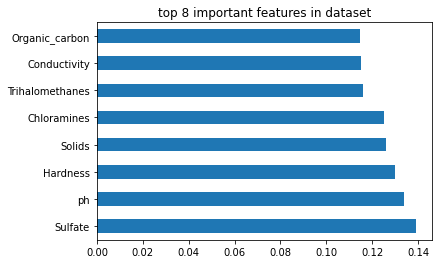

In [73]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.title('top 8 important features in dataset')
plt.show()

In [85]:
draws= 50
trace_df = pm.trace_to_dataframe(trace).assign(
    chain= lambda x: x.index //draws
)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Intercept        4000 non-null   float64
 1   Sulfate          4000 non-null   float64
 2   Hardness         4000 non-null   float64
 3   ph               4000 non-null   float64
 4   Conductivity     4000 non-null   float64
 5   Organic_carbon   4000 non-null   float64
 6   Solids           4000 non-null   float64
 7   Chloramines      4000 non-null   float64
 8   Trihalomethanes  4000 non-null   float64
 9   Turbidity        4000 non-null   float64
 10  chain            4000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 343.9 KB


In [86]:
with open(model_path/ 'logistic_model_nuts.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'trace': trace}, buff)

Convergence

In [95]:
trace_df_long = pd.melt(trace_df, id_vars=[ 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   chain     40000 non-null  int64  
 1   variable  40000 non-null  object 
 2   value     40000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 937.6+ KB


ADVI

In [96]:
with logistic_model:
  callback = CheckParametersConvergence(diff='absolute')
  approx = pm.fit(n=1000, callbacks = [callback])

Finished [100%]: Average Loss = 1.8842e+05


Sample from approximared dist

In [98]:
trace_advi = approx.sample(2000)
trace_advi

<MultiTrace: 1 chains, 2000 iterations, 10 variables>

In [99]:
pm.summary(trace_advi)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.152,0.727,-1.203,1.456,0.017,0.012,1931.0,1886.0,NaN
Sulfate,-0.144,0.689,-1.447,1.127,0.016,0.012,1758.0,1802.0,NaN
Hardness,-0.142,0.688,-1.502,1.102,0.016,0.011,1845.0,1886.0,NaN
ph,-0.152,0.720,-1.603,1.112,0.016,0.012,1923.0,1962.0,NaN
Conductivity,-0.154,0.682,-1.434,1.111,0.015,0.011,2038.0,1855.0,NaN
Organic_carbon,-0.136,0.717,-1.554,1.130,0.016,0.011,2025.0,2001.0,NaN
Solids,0.132,0.628,-0.990,1.363,0.014,0.010,1917.0,1678.0,NaN
Chloramines,0.146,0.697,-1.194,1.426,0.016,0.012,1976.0,1724.0,NaN
Trihalomethanes,0.140,0.710,-1.213,1.477,0.016,0.012,1881.0,1779.0,NaN
Turbidity,0.171,0.726,-1.266,1.457,0.016,0.012,2144.0,1762.0,NaN


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:242: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


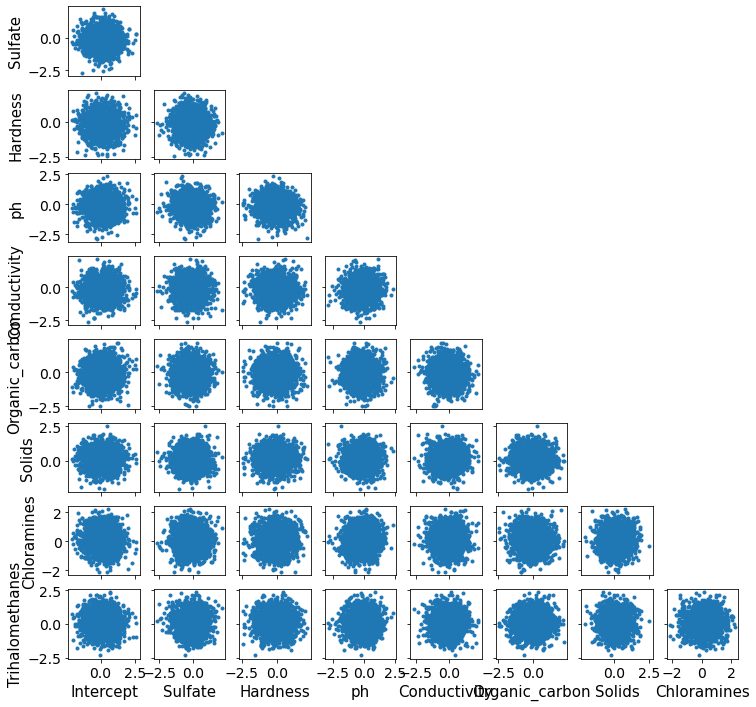

In [101]:
az.plot_pair(trace_advi, figsize=(12,12));

# Model diagnostics

Bayesian model diagnostics includes validating that the sampling process has converged and consistentlysamples from high-probability areas of the posterior, and confirming that the model represents the data well.
For high-dimensional models with many variables, it becomes cumbersome to inspect numerous traces. Whenusing NUTS, the energy plot helps to assess problems of convergence. It summarizes how efficiently the randomprocess explores the posterior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


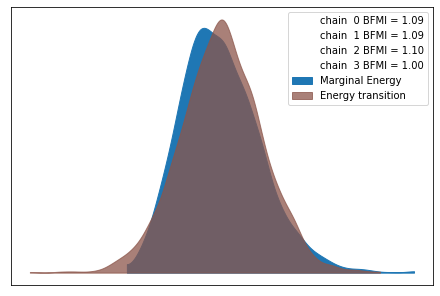

In [103]:
pm.energyplot(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac74c4c0d0>,
      dtype=object)

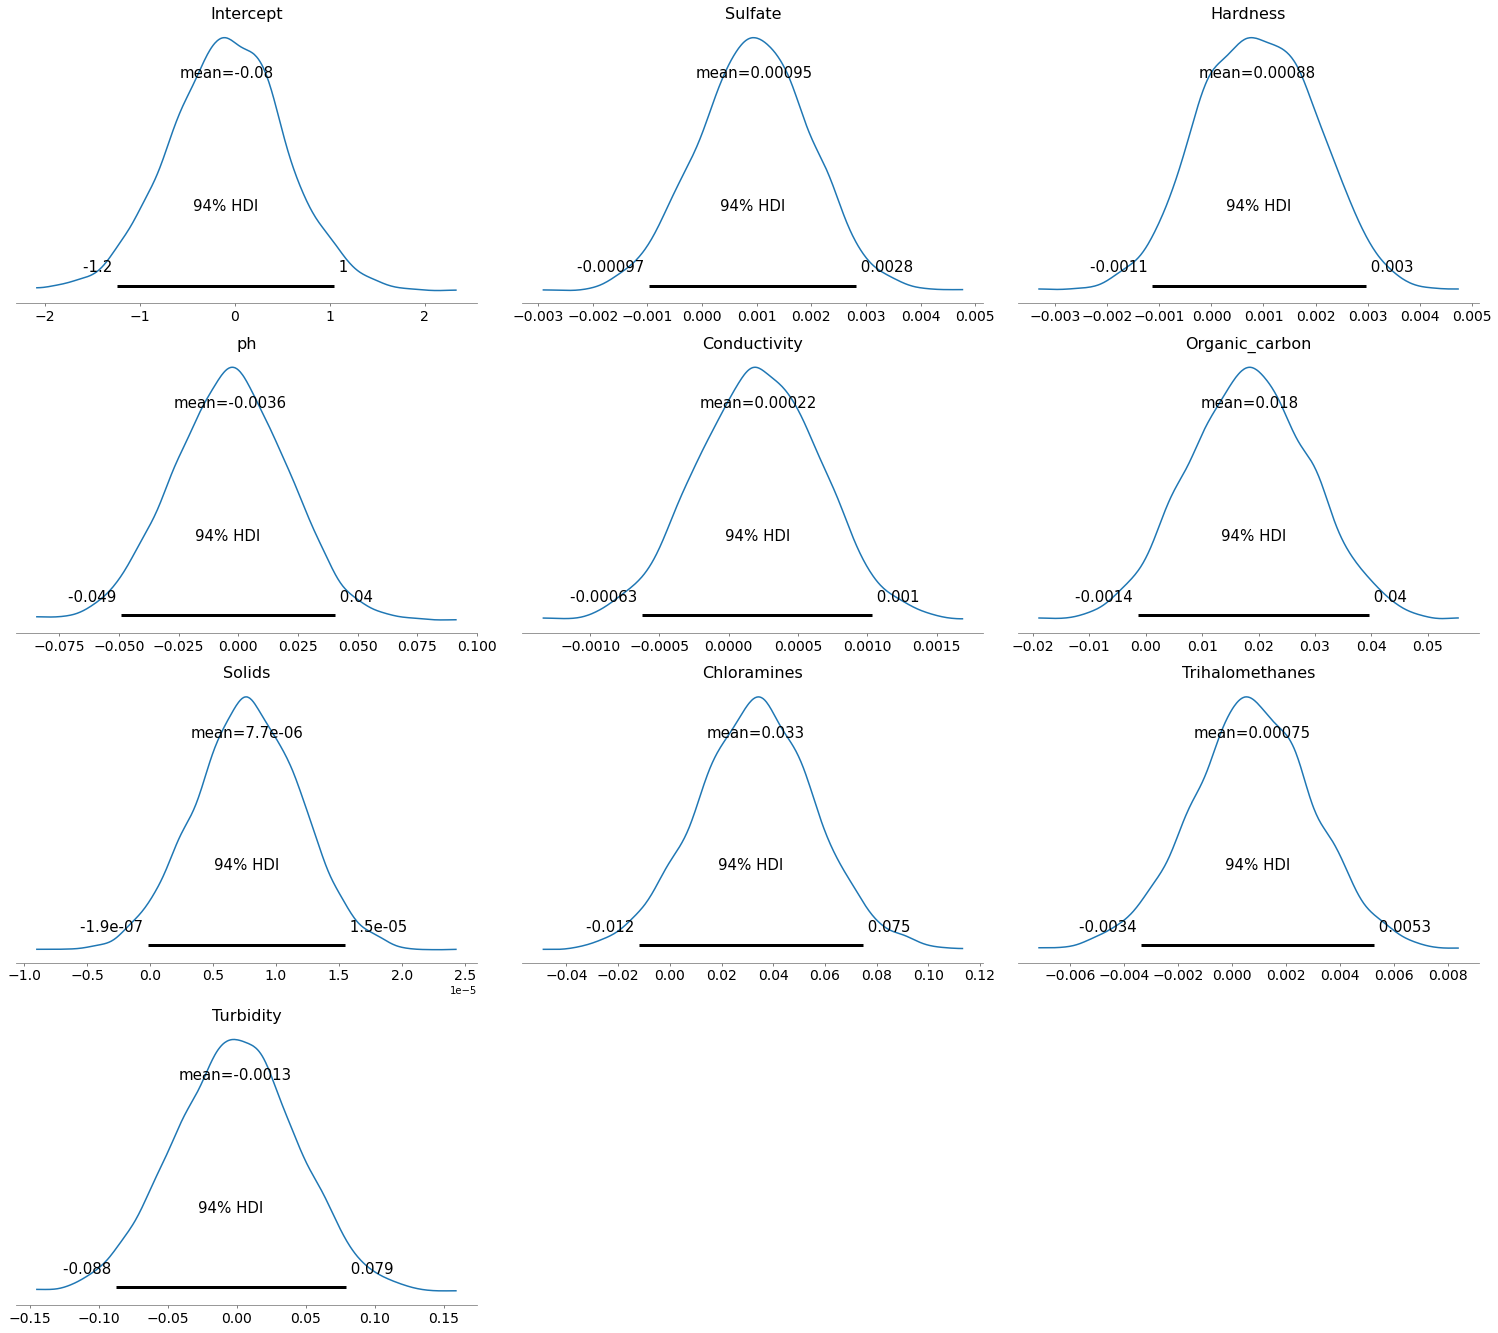

In [105]:
pm.plot_posterior(trace)

Posterior Predictive Checks

In [107]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = logistic_model)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [108]:
ppc['y'].shape

(1000, 3276)

Check AUC Score

In [109]:
y_score = np.mean (ppc['y'], axis = 0)

In [111]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,accuracy_score,f1_score)

In [113]:
pred_scores = dict(y_true = dt.Potability, y_score = y_score)
roc_auc_score(**pred_scores)

0.5179485040596151

In [120]:
X = dt.drop('Potability', axis=1)
y = dt.Potability
x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state =42)
labels = x_train.columns

Create shared theano variable

In [118]:
import theano 

In [121]:
x_shared = theano.shared(x_train.values)

define log model

In [122]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=x_shared, labels=labels,
               y=y_train, family = pm.glm.families.Binomial())

In [123]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=1000,
                           tune=1000,
                           chains=2,
                           cores=2,
                           init = 'adapt_diag')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Turbidity, Trihalomethanes, Organic_carbon, Conductivity, Sulfate, Chloramines, Solids, Hardness, ph, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 258 seconds.


now we gonna replace shared variable with test set
then we run th sampler as before, and apply pm.sample_ppc function to the resulting trace after replacing the train with test data

In [124]:
x_shared.set_value(x_test)

In [125]:
ppc = pm.sample_posterior_predictive(pred_trace,
                                     model = logistic_model_pred,
                                     samples = 1000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


AUC score

In [128]:
y_score = np.mean(ppc['y'], axis =0)
roc_auc_score(y_score = np.mean(ppc['y'], axis=0),
              y_true = y_test)

0.5208300175075601

In [131]:
pred_scores = dict(y_true = y_test, y_score = y_score)
cols = ['false positive rate', 'true postive rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [133]:
from sklearn.metrics import precision_recall_curve

In [136]:
precision, recall, ts = precision_recall_curve(y_true = y_test, probas_pred = y_score)
pre_curve = pd.DataFrame({'Precision': precision,'Recall': recall})
pre_curve

,Precision,Recall
0,0.373089,1.000000
1,0.372129,0.995902
2,0.371166,0.991803
3,0.371736,0.991803
4,0.370769,0.987705
...,...,...
138,0.250000,0.004098
139,0.333333,0.004098
140,0.000000,0.000000
141,0.000000,0.000000


f1_score

In [138]:
f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

# Classification Models
In this section we use inbuilt models from Scikit-Learn to predict our target variable and output our accuracy
there are numerous different classification algorithms, of which we will not go into depth. Among these classifiers are


*   K-Nearest Neighbors
*   Support Vector Machines
*   Decision Tree Classifier/Random Forests
*   Naive Bayes
*   Linear Discriminant Analysis
*   Logistic Regression

for the purpose of this project we will only choose three of the above..

if one wants to learn a lot of literature on how various classifiers work and some brief explainations of them can be found at https://scikit-learn.org/stable/user_guide.html



In [72]:
dt.Potability

0       0
1       0
2       0
3       0
4       0
       ..
3271    1
3272    1
3273    1
3274    1
3275    1
Name: Potability, Length: 3276, dtype: int64

standardize the data

In [74]:
x_dt = dt.drop(['Potability'], axis =1)
x = x_dt.iloc[:,0:8]
y = dt.Potability
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=111)

Text(0.5, 1.0, 'Feature distribution after scaling')

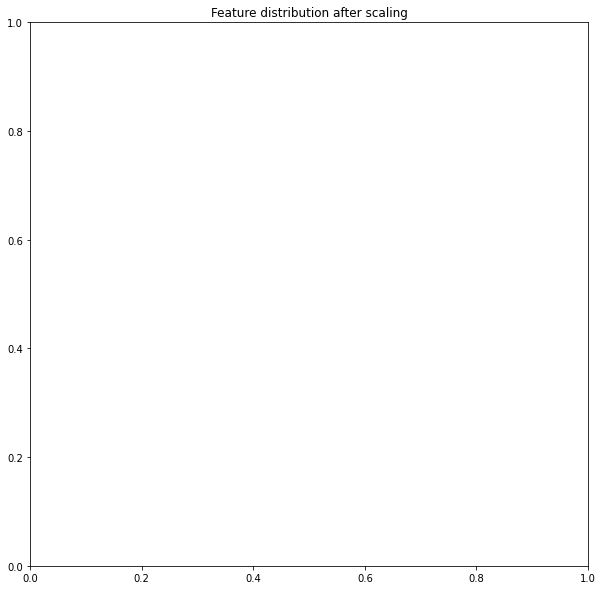

In [75]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)
fig = plt.subplots(ncols=1, figsize=(10,10))
sns.kdeplot(dt=x_train)
plt.title('Feature distribution after scaling')

In [76]:
from sklearn.svm import SVC
model = SVC(random_state = 1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Classification Report for Support Vector Machine')
print(classification_report(y_test, y_pred))

Classification Report for Support Vector Machine
              precision    recall  f1-score   support

           0       0.71      0.93      0.80       417
           1       0.73      0.33      0.46       239

    accuracy                           0.71       656
   macro avg       0.72      0.63      0.63       656
weighted avg       0.72      0.71      0.68       656



In [77]:
# save the model to disk
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))


# Support vector machine
Support vector macghine is a supervised ML algorithm which is used for classification and regression challenges. However it is mostly used in classification problems. in SVM algorithm, each data is plotted as a point in n-dimensional space(number of features selected) with value of feature being the value of a particular co-ordinate(not done in this project).

**Advantages**


*   works really well with a clear margin of separation
*   very effective in high dimensional spaces
* effective in cases where the number of dimensions is greater than the number of samples
* uses susbsets of train points in the decision function

**Cons**


*   does not perform well when we have large dataset because of the required training time is higher
*   does not perform well, when the data has more noise for example when the target classes are overlapping





In [78]:
from sklearn.linear_model import LogisticRegression
model_2 = LogisticRegression(random_state = 1)
model_2.fit(x_train, y_train)
y_pred_2 = model_2.predict(x_test)
print('Classification report for logistic Regression')
print(classification_report(y_test, y_pred_2))

Classification report for logistic Regression
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       417
           1       1.00      0.00      0.01       239

    accuracy                           0.64       656
   macro avg       0.82      0.50      0.39       656
weighted avg       0.77      0.64      0.50       656



In [79]:
# save the model to disk
filename = 'model_2.sav'
pickle.dump(model_2, open(filename, 'wb'))

# Logistic Regression
Logistic regression is appropriate regression analysis to conduction when dependent variable is binary (or dichotomous).
like all regression analyses, the logistic regression is a predictive analysis, which is used to descrive data and explain relation between one dependent binary variable and one or more nominal,ordinal, interval or ratio-level independent variables.

Binary Logistic Regression Major Assumptions
* dependent variable should be dichotomous in nature
* no outliers in the data, which can be assesed by converting the continuous predictors to standardized scores
* no multicollinearity among predictors.
Tabachnick and Fidell (2013) suggests that as long correlation coefficents among independent variables < 0.90 the assumption is met.

**Advantages**

* logistics regression is easier to implement, interpret, and very efficient to train
* makes no assumption about distributions of classes in feature space.
* extend to multiple classes and natural probabilistic view of class predictions

**Disadvantages**

* if number of observations is less than the of features, it may lead to overfitting
* constructs linear boundaries
* major limitation of Logistic regression is the assumption of linearity between the dependent variable and independent variables


In [80]:
from sklearn.tree import DecisionTreeClassifier
model_3 = DecisionTreeClassifier(random_state = 1)
model_3.fit(x_train, y_train)
y_pred_3 = model_3.predict(x_test)
print('classification report for DTC')
print(classification_report(y_test, y_pred_3))

classification report for DTC
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       417
           1       0.49      0.51      0.50       239

    accuracy                           0.63       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.63      0.63      0.63       656



In [81]:
# save the model to disk
filename = 'model_3.sav'
pickle.dump(model_3, open(filename, 'wb'))

# Decision Tree Classifier
decision trer is a simple representation for classifying  examples. it is a supervied Machine learning where the data is continuously split according to a certain paramter.

**Advantages**

* useful for decision-related problems.
* find all the possible outcomes for a given problem.
* there is a very littel need for data cleaning in decision trees compared to other machine learning algorithms.

**Disadvantages**

* too many layers of decision tree make it extremely somtimes
* results in overfitting
* more number of class labels, computational complexity of the decision tree increases

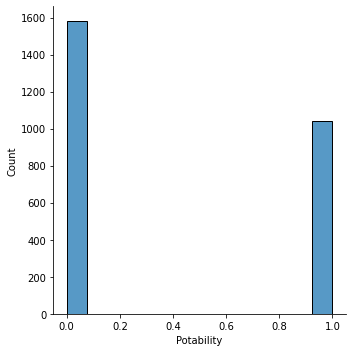

In [82]:
sns.displot(y_train)

In [84]:
b = trace['inter']
lb, ub = np.percentile(b, 2.5), np.percentile(b,97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f}< Odds Ratio < {ub:.3f})= 0.95')

KeyError: ignored